In [39]:
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Replace with your actual Etherscan API key
ETHERSCAN_API_KEY = "C7SW24Q337H8G9FV3T9FMB424R1SJ5VIG3"  # Replace this with your actual key

# API Endpoints
ETHERSCAN_BASE = "https://api.etherscan.io/api"

# Compound V2 Contract Addresses
COMPOUND_V2_CONTRACTS = {
    'cETH': '0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5',
    'cDAI': '0x5d3a536e4d6dbd6114cc1ead35777bab948e3643', 
    'cUSDC': '0x39aa39c021dfbaae8fac545936693ac917d5e7563',
    'cUSDT': '0xf650c3d88d12db855b8bf7d11be6c55a4e07dcc9',
    'cWBTC': '0xc11b1268c1a384e55c48c2391d8d480264a3a7f4',
    'cWBTC2': '0xccf4429db6322d5c611ee964527d42e5d685dd6a',
    'cBAT': '0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e',
    'cREP': '0x158079ee67fce2f58472a96584a73c7ab9ac95c1',
    'cZRX': '0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407',
    'comptroller': '0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b'
}

# Compound V3 Contracts
COMPOUND_V3_CONTRACTS = {
    'cUSDCv3': '0xc3d688b66703497daa19211eedff47f25384cdc3',
    'cWETHv3': '0xa17581a9e3356d9a858b789d68b4d866e593ae94',
    'cWBTCv3': '0x9c4ec768c28520b50860ea7a15bd7213a9ff58bf'
}

ALL_COMPOUND_CONTRACTS = {**COMPOUND_V2_CONTRACTS, **COMPOUND_V3_CONTRACTS}

# Method signatures for Compound operations
COMPOUND_METHODS = {
    'mint': '0xa0712d68',
    'redeem': '0xdb006a75',
    'borrow': '0xc5ebeaec',
    'repayBorrow': '0x0e752702',
    'liquidateBorrow': '0xf5e3c462'
}

print("✅ Environment setup complete!")
print(f"📋 Monitoring {len(ALL_COMPOUND_CONTRACTS)} Compound contracts")
print(f"🔍 Looking for {len(COMPOUND_METHODS)} types of operations")

✅ Environment setup complete!
📋 Monitoring 13 Compound contracts
🔍 Looking for 5 types of operations


In [40]:
# Load the wallet addresses from your CSV file
df_wallets = pd.read_csv('Wallet id - Sheet1.csv')
wallet_addresses = [addr.lower().strip() for addr in df_wallets['wallet_id'].tolist()]

print(f"✅ Loaded {len(wallet_addresses)} wallet addresses from CSV")
print("📋 First 5 addresses:")
for i, addr in enumerate(wallet_addresses[:5]):
    print(f"  {i+1}. {addr}")
    
print(f"📋 Last 5 addresses:")
for i, addr in enumerate(wallet_addresses[-5:], len(wallet_addresses)-4):
    print(f"  {i}. {addr}")

✅ Loaded 103 wallet addresses from CSV
📋 First 5 addresses:
  1. 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
  2. 0x06b51c6882b27cb05e712185531c1f74996dd988
  3. 0x0795732aacc448030ef374374eaae57d2965c16c
  4. 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
  5. 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
📋 Last 5 addresses:
  99. 0xf60304b534f74977e159b2e159e135475c245526
  100. 0xf67e8e5805835465f7eba988259db882ab726800
  101. 0xf7aa5d0752cfcd41b0a5945867d619a80c405e52
  102. 0xf80a8b9cfff0febf49914c269fb8aead4a22f847
  103. 0xfe5a05c0f8b24fca15a7306f6a4ebb7dcf2186ac


In [41]:
def get_etherscan_transactions(address):
    """Get transaction history from Etherscan API"""
    
    params = {
        'module': 'account',
        'action': 'txlist',
        'address': address,
        'startblock': 0,
        'endblock': 'latest',
        'sort': 'desc',
        'apikey': ETHERSCAN_API_KEY
    }
    
    try:
        response = requests.get(ETHERSCAN_BASE, params=params, timeout=10)
        data = response.json()
        
        if data['status'] == '1':
            return data['result']
        else:
            return []
            
    except Exception as e:
        print(f"❌ Error fetching transactions for {address}: {str(e)}")
        return []

def get_erc20_transfers(address):
    """Get ERC20 token transfers"""
    
    params = {
        'module': 'account',
        'action': 'tokentx',
        'address': address,
        'startblock': 0,
        'endblock': 'latest',
        'sort': 'desc',
        'apikey': ETHERSCAN_API_KEY
    }
    
    try:
        response = requests.get(ETHERSCAN_BASE, params=params, timeout=10)
        data = response.json()
        
        if data['status'] == '1':
            return data['result']
        else:
            return []
            
    except Exception as e:
        print(f"❌ Error fetching ERC20 transfers for {address}: {str(e)}")
        return []

def filter_compound_transactions(transactions, erc20_transfers):
    """Filter transactions related to Compound protocol"""
    
    compound_txs = []
    compound_addresses = [addr.lower() for addr in ALL_COMPOUND_CONTRACTS.values()]
    
    # Regular transactions to/from Compound contracts
    for tx in transactions:
        to_addr = tx.get('to', '').lower()
        from_addr = tx.get('from', '').lower()
        
        if to_addr in compound_addresses or from_addr in compound_addresses:
            tx['tx_type'] = 'regular'
            compound_txs.append(tx)
    
    # ERC20 transfers involving cTokens
    for tx in erc20_transfers:
        contract_addr = tx.get('contractAddress', '').lower()
        
        if contract_addr in compound_addresses:
            tx['tx_type'] = 'erc20'
            compound_txs.append(tx)
    
    return compound_txs

def analyze_compound_operations(compound_txs):
    """Analyze Compound operations from transaction data"""
    
    operations = {
        'supply_count': 0,
        'withdraw_count': 0,
        'borrow_count': 0,
        'repay_count': 0,
        'liquidation_count': 0,
        'total_tx_count': len(compound_txs),
        'first_interaction': None,
        'last_interaction': None,
        'unique_contracts': set(),
        'total_eth_value': 0,
        'avg_tx_value': 0
    }
    
    if not compound_txs:
        return operations
    
    # Sort by timestamp
    sorted_txs = sorted(compound_txs, key=lambda x: int(x.get('timeStamp', 0)))
    
    if sorted_txs:
        operations['first_interaction'] = datetime.fromtimestamp(int(sorted_txs[0]['timeStamp']))
        operations['last_interaction'] = datetime.fromtimestamp(int(sorted_txs[-1]['timeStamp']))
    
    total_value = 0
    
    for tx in compound_txs:
        # Track unique contracts
        if 'to' in tx and tx['to']:
            operations['unique_contracts'].add(tx['to'].lower())
        if 'contractAddress' in tx and tx['contractAddress']:
            operations['unique_contracts'].add(tx['contractAddress'].lower())
            
        # Get transaction value
        value = int(tx.get('value', 0))
        if value > 0:
            total_value += value
        
        # Analyze method signatures to classify operations
        method_id = tx.get('input', '')[:10] if tx.get('input') else ''
        
        if method_id == COMPOUND_METHODS['mint']:
            operations['supply_count'] += 1
        elif method_id == COMPOUND_METHODS['redeem']:
            operations['withdraw_count'] += 1
        elif method_id == COMPOUND_METHODS['borrow']:
            operations['borrow_count'] += 1
        elif method_id == COMPOUND_METHODS['repayBorrow']:
            operations['repay_count'] += 1
        elif method_id == COMPOUND_METHODS['liquidateBorrow']:
            operations['liquidation_count'] += 1
        else:
            # Fallback classification based on transaction context
            if tx['tx_type'] == 'erc20':
                operations['supply_count'] += 1  # cToken transfers usually indicate supply/redeem
            elif value > 0:
                operations['supply_count'] += 1  # ETH transactions usually supply/repay
    
    operations['unique_contracts'] = len(operations['unique_contracts'])
    operations['total_eth_value'] = total_value / 1e18
    operations['avg_tx_value'] = operations['total_eth_value'] / max(len(compound_txs), 1)
    
    return operations

print("✅ Data collection functions defined")

✅ Data collection functions defined


In [42]:
def collect_wallet_data(wallet_addresses, max_wallets=None):
    """Collect real Compound protocol data for all wallets"""
    
    if max_wallets:
        wallet_addresses = wallet_addresses[:max_wallets]
    
    wallet_data = []
    failed_wallets = []
    
    print(f"🔄 Starting data collection for {len(wallet_addresses)} wallets...")
    print("⏱️ This will take several minutes due to API rate limits...")
    
    for i, wallet in enumerate(tqdm(wallet_addresses, desc="Processing wallets")):
        try:
            # Rate limiting - respect Etherscan free tier (5 calls/second)
            time.sleep(0.25)
            
            # Get transaction data
            regular_txs = get_etherscan_transactions(wallet)
            time.sleep(0.25)  # Additional delay between API calls
            
            erc20_transfers = get_erc20_transfers(wallet)
            
            # Filter for Compound interactions
            compound_txs = filter_compound_transactions(regular_txs, erc20_transfers)
            
            # Analyze operations
            operations = analyze_compound_operations(compound_txs)
            
            # Calculate time-based metrics
            days_active = 1  # Default minimum
            if operations['first_interaction'] and operations['last_interaction']:
                days_active = max((operations['last_interaction'] - operations['first_interaction']).days, 1)
            
            # Store wallet data
            wallet_data.append({
                'wallet_id': wallet,
                'total_compound_txs': operations['total_tx_count'],
                'supply_operations': operations['supply_count'],
                'withdraw_operations': operations['withdraw_count'],
                'borrow_operations': operations['borrow_count'],
                'repay_operations': operations['repay_count'],
                'liquidation_operations': operations['liquidation_count'],
                'unique_compound_contracts': operations['unique_contracts'],
                'total_eth_transacted': operations['total_eth_value'],
                'avg_transaction_value': operations['avg_tx_value'],
                'days_active': days_active,
                'first_interaction': operations['first_interaction'],
                'last_interaction': operations['last_interaction'],
                'has_compound_activity': operations['total_tx_count'] > 0
            })
            
            # Progress update every 10 wallets
            if (i + 1) % 10 == 0:
                active_wallets = sum(1 for w in wallet_data if w['has_compound_activity'])
                print(f"📊 Progress: {i+1}/{len(wallet_addresses)} | Active: {active_wallets}")
                
        except Exception as e:
            print(f"❌ Failed to process wallet {wallet}: {str(e)}")
            failed_wallets.append(wallet)
            continue
    
    # Convert to DataFrame
    df_collected = pd.DataFrame(wallet_data)
    
    # Summary
    active_wallets = df_collected['has_compound_activity'].sum()
    total_transactions = df_collected['total_compound_txs'].sum()
    
    print(f"\n✅ Data collection complete!")
    print(f"📊 Summary:")
    print(f"   - Total wallets processed: {len(df_collected)}")
    print(f"   - Wallets with Compound activity: {active_wallets}")
    print(f"   - Wallets with no activity: {len(df_collected) - active_wallets}")
    print(f"   - Total Compound transactions: {total_transactions}")
    print(f"   - Failed wallets: {len(failed_wallets)}")
    
    return df_collected

# Start data collection
print("🚀 Starting real data collection...")
# NOW ACTUALLY CALL THE FUNCTION!
print("🚀 Starting real data collection...")
df_raw_data = collect_wallet_data(wallet_addresses)

print("\n📋 Sample of collected data:")
print(df_raw_data[['wallet_id', 'total_compound_txs', 'has_compound_activity']].head())

🚀 Starting real data collection...
🚀 Starting real data collection...
🔄 Starting data collection for 103 wallets...
⏱️ This will take several minutes due to API rate limits...


Processing wallets:  10%|▉         | 10/103 [00:39<05:44,  3.70s/it]

📊 Progress: 10/103 | Active: 3


Processing wallets:  19%|█▉        | 20/103 [01:14<04:36,  3.33s/it]

📊 Progress: 20/103 | Active: 6


Processing wallets:  29%|██▉       | 30/103 [01:50<04:21,  3.58s/it]

📊 Progress: 30/103 | Active: 12


Processing wallets:  39%|███▉      | 40/103 [02:23<03:20,  3.18s/it]

📊 Progress: 40/103 | Active: 14


Processing wallets:  49%|████▊     | 50/103 [02:58<03:08,  3.55s/it]

📊 Progress: 50/103 | Active: 19


Processing wallets:  58%|█████▊    | 60/103 [03:31<02:28,  3.45s/it]

📊 Progress: 60/103 | Active: 24


Processing wallets:  68%|██████▊   | 70/103 [04:06<02:02,  3.72s/it]

📊 Progress: 70/103 | Active: 30


Processing wallets:  78%|███████▊  | 80/103 [04:42<01:20,  3.52s/it]

📊 Progress: 80/103 | Active: 38


Processing wallets:  87%|████████▋ | 90/103 [05:20<00:45,  3.46s/it]

📊 Progress: 90/103 | Active: 44


Processing wallets:  97%|█████████▋| 100/103 [05:57<00:10,  3.63s/it]

📊 Progress: 100/103 | Active: 49


Processing wallets: 100%|██████████| 103/103 [06:07<00:00,  3.57s/it]


✅ Data collection complete!
📊 Summary:
   - Total wallets processed: 103
   - Wallets with Compound activity: 50
   - Wallets with no activity: 53
   - Total Compound transactions: 598
   - Failed wallets: 0

📋 Sample of collected data:
                                    wallet_id  total_compound_txs  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3                  32   
1  0x06b51c6882b27cb05e712185531c1f74996dd988                   0   
2  0x0795732aacc448030ef374374eaae57d2965c16c                   0   
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9                   0   
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae                   0   

   has_compound_activity  
0                   True  
1                  False  
2                  False  
3                  False  
4                  False  


In [49]:
def engineer_risk_features(df_raw):
    """Create comprehensive risk features from collected data"""
    
    df_features = df_raw.copy()
    df_features = df_features.fillna(0)
    
    print("🔧 Engineering risk features...")
    
    # Fix the unique_compound_contracts field - convert sets to counts
    df_features['unique_compound_contracts'] = df_features['unique_compound_contracts'].apply(
        lambda x: len(x) if isinstance(x, set) else x if isinstance(x, (int, float)) else 0
    )
    
    # 1. ACTIVITY RISK
    df_features['activity_risk_score'] = np.where(
        df_features['total_compound_txs'] == 0, 100,
        np.where(df_features['total_compound_txs'] < 5, 75,
                np.where(df_features['total_compound_txs'] < 20, 50, 25))
    )
    
    # 2. LIQUIDATION RISK
    df_features['liquidation_risk_score'] = np.minimum(
        df_features['liquidation_operations'] * 300, 100
    )
    
    # 3. BORROWING BEHAVIOR RISK
    df_features['total_operations'] = (
        df_features['supply_operations'] + 
        df_features['withdraw_operations'] + 
        df_features['borrow_operations'] + 
        df_features['repay_operations']
    )
    
    df_features['borrow_ratio'] = np.where(
        df_features['total_operations'] > 0,
        df_features['borrow_operations'] / df_features['total_operations'],
        0
    )
    
    df_features['borrowing_risk_score'] = np.where(
        df_features['borrow_ratio'] > 0.6, 100,
        np.where(df_features['borrow_ratio'] > 0.3, 75,
                np.where(df_features['borrow_ratio'] > 0.1, 50, 25))
    )
    
    # 4. CONCENTRATION RISK (now fixed)
    df_features['concentration_risk_score'] = np.where(
        df_features['unique_compound_contracts'] <= 1, 100,
        np.where(df_features['unique_compound_contracts'] <= 2, 75,
                np.where(df_features['unique_compound_contracts'] <= 3, 50, 25))
    )
    
    # 5. TRANSACTION SIZE RISK
    df_features['size_risk_score'] = np.where(
        df_features['avg_transaction_value'] > 50, 75,
        np.where(df_features['avg_transaction_value'] > 10, 50,
                np.where(df_features['avg_transaction_value'] > 1, 25, 10))
    )
    
    # 6. TIME-BASED RISK
    df_features['time_risk_score'] = np.where(
        df_features['days_active'] < 30, 75,
        np.where(df_features['days_active'] > 1000, 50, 25)
    )
    
    # 7. PORTFOLIO BALANCE RISK
    df_features['balance_risk_score'] = np.where(
        (df_features['supply_operations'] == 0) & (df_features['borrow_operations'] > 0), 100,
        np.where((df_features['borrow_operations'] == 0) & (df_features['supply_operations'] > 0), 25,
                np.where(df_features['total_operations'] > 0, 50, 0))
    )
    
    # 8. FREQUENCY RISK
    df_features['tx_frequency'] = np.where(
        df_features['days_active'] > 0,
        df_features['total_compound_txs'] / df_features['days_active'],
        0
    )
    
    df_features['frequency_risk_score'] = np.where(
        df_features['tx_frequency'] > 1, 75,
        np.where(df_features['tx_frequency'] > 0.1, 25,
                np.where(df_features['tx_frequency'] > 0, 50, 100))
    )
    
    print("✅ Risk features engineered successfully")
    
    # Feature summary
    risk_features = [
        'activity_risk_score', 'liquidation_risk_score', 'borrowing_risk_score',
        'concentration_risk_score', 'size_risk_score', 'time_risk_score',
        'balance_risk_score', 'frequency_risk_score'
    ]
    
    print("\n📊 Risk Feature Summary:")
    for feature in risk_features:
        mean_score = df_features[feature].mean()
        max_score = df_features[feature].max()
        print(f"   {feature}: Mean={mean_score:.1f}, Max={max_score:.1f}")
    
    # Debug info
    print(f"\n🔍 Debug Info:")
    print(f"   Unique contracts range: {df_features['unique_compound_contracts'].min()} - {df_features['unique_compound_contracts'].max()}")
    print(f"   Sample unique_compound_contracts values: {df_features['unique_compound_contracts'].head().tolist()}")
    
    return df_features

# Apply feature engineering
df_features = engineer_risk_features(df_raw_data)

🔧 Engineering risk features...
✅ Risk features engineered successfully

📊 Risk Feature Summary:
   activity_risk_score: Mean=80.8, Max=100.0
   liquidation_risk_score: Mean=0.0, Max=0.0
   borrowing_risk_score: Mean=26.0, Max=75.0
   concentration_risk_score: Mean=81.8, Max=100.0
   size_risk_score: Mean=10.5, Max=50.0
   time_risk_score: Mean=67.5, Max=75.0
   balance_risk_score: Mean=12.9, Max=50.0
   frequency_risk_score: Mean=76.9, Max=100.0

🔍 Debug Info:
   Unique contracts range: 0 - 12
   Sample unique_compound_contracts values: [9, 0, 0, 0, 0]


In [50]:
def calculate_final_risk_score(df_features):
    """Calculate final risk score using weighted combination"""
    
    print("🎯 Calculating final risk scores...")
    
    # Risk factor weights (sum = 1.0)
    weights = {
        'activity_risk_score': 0.20,
        'liquidation_risk_score': 0.25,
        'borrowing_risk_score': 0.15,
        'concentration_risk_score': 0.15,
        'balance_risk_score': 0.10,
        'size_risk_score': 0.05,
        'time_risk_score': 0.05,
        'frequency_risk_score': 0.05
    }
    
    print(f"📊 Risk weights: {weights}")
    
    # Calculate weighted score
    df_features['weighted_risk_score'] = 0
    for factor, weight in weights.items():
        df_features['weighted_risk_score'] += df_features[factor] * weight
    
    # Normalize to 0-1000 scale
    scaler = MinMaxScaler(feature_range=(0, 1000))
    df_features['risk_score'] = scaler.fit_transform(
        df_features['weighted_risk_score'].values.reshape(-1, 1)
    ).flatten()
    
    # Round to integers, ensure minimum 1
    df_features['risk_score'] = np.maximum(df_features['risk_score'].round().astype(int), 1)
    
    print("✅ Risk scores calculated successfully")
    
    # Distribution summary
    print(f"\n📊 Risk Score Distribution:")
    print(f"   Mean: {df_features['risk_score'].mean():.1f}")
    print(f"   Median: {df_features['risk_score'].median():.1f}")
    print(f"   Min: {df_features['risk_score'].min()}")
    print(f"   Max: {df_features['risk_score'].max()}")
    
    # Risk categories
    low = (df_features['risk_score'] <= 300).sum()
    medium = ((df_features['risk_score'] > 300) & (df_features['risk_score'] <= 600)).sum()
    high = (df_features['risk_score'] > 600).sum()
    
    print(f"\n🎯 Risk Categories:")
    print(f"   Low Risk (0-300): {low} wallets")
    print(f"   Medium Risk (301-600): {medium} wallets")
    print(f"   High Risk (601-1000): {high} wallets")
    
    return df_features

# Calculate final scores
df_final = calculate_final_risk_score(df_features)

🎯 Calculating final risk scores...
📊 Risk weights: {'activity_risk_score': 0.2, 'liquidation_risk_score': 0.25, 'borrowing_risk_score': 0.15, 'concentration_risk_score': 0.15, 'balance_risk_score': 0.1, 'size_risk_score': 0.05, 'time_risk_score': 0.05, 'frequency_risk_score': 0.05}
✅ Risk scores calculated successfully

📊 Risk Score Distribution:
   Mean: 758.7
   Median: 1000.0
   Min: 1
   Max: 1000

🎯 Risk Categories:
   Low Risk (0-300): 11 wallets
   Medium Risk (301-600): 16 wallets
   High Risk (601-1000): 76 wallets


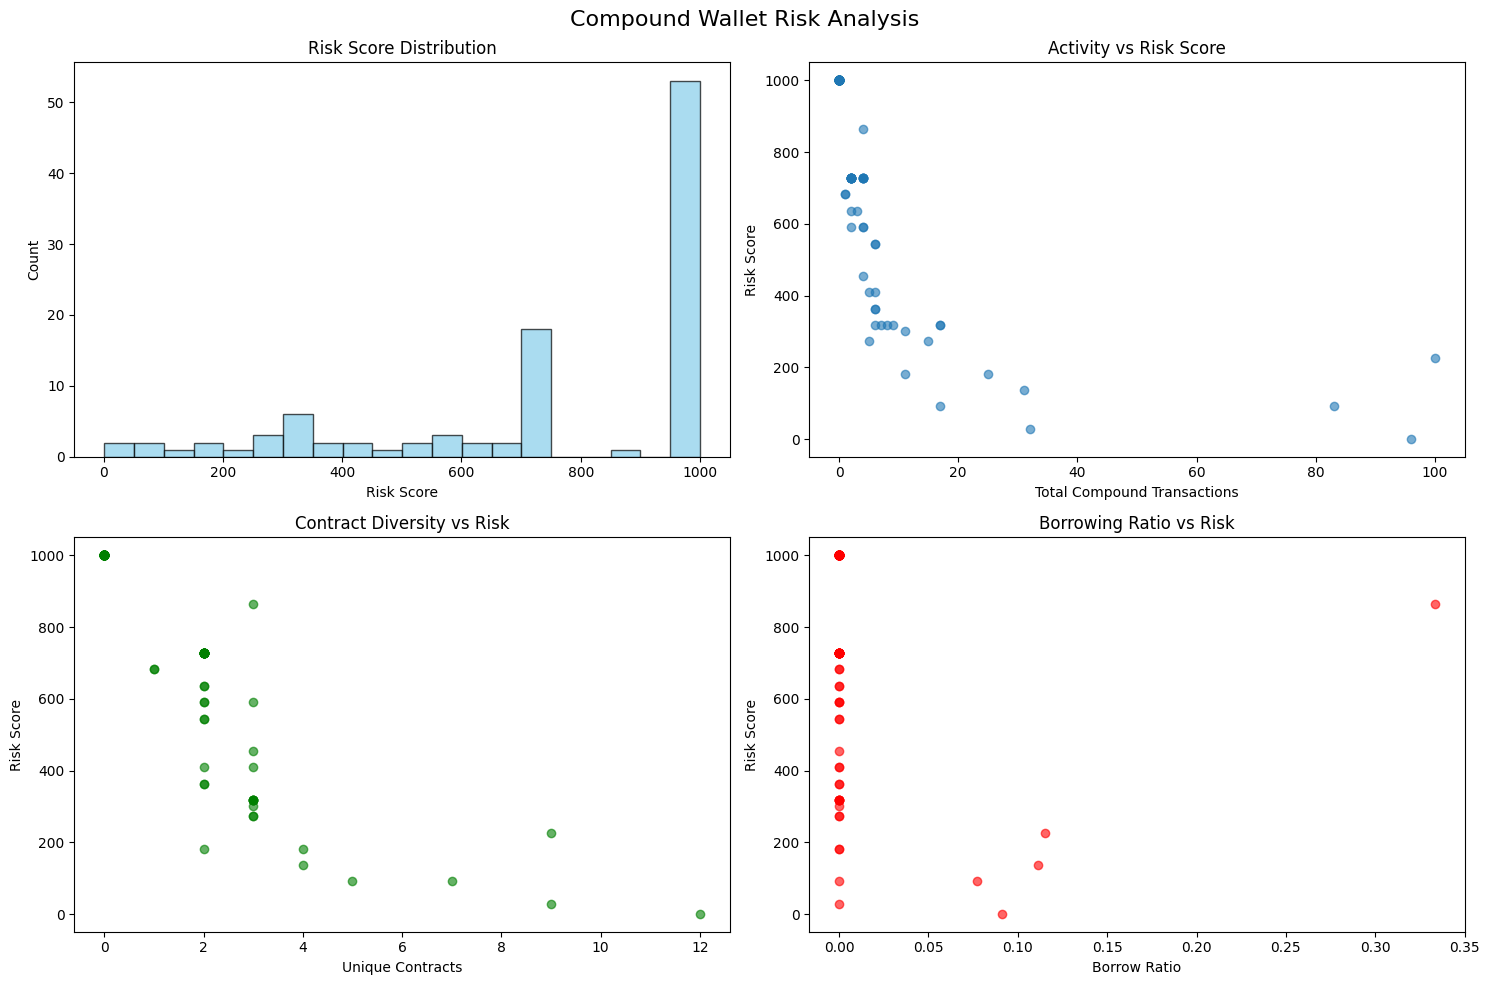


🚨 TOP 10 HIGHEST RISK WALLETS:
                                 wallet_id  risk_score  total_compound_txs  liquidation_operations
0x06b51c6882b27cb05e712185531c1f74996dd988        1000                   0                       0
0x0795732aacc448030ef374374eaae57d2965c16c        1000                   0                       0
0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9        1000                   0                       0
0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae        1000                   0                       0
0x104ae61d8d487ad689969a17807ddc338b445416        1000                   0                       0
0x111c7208a7e2af345d36b6d4aace8740d61a3078        1000                   0                       0
0x13b1c8b0e696aff8b4fee742119b549b605f3cbc        1000                   0                       0
0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22        1000                   0                       0
0x19df3e87f73c4aaf4809295561465b993e102668        1000                   0   

In [51]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Compound Wallet Risk Analysis', fontsize=16)

# 1. Risk Score Distribution
axes[0,0].hist(df_final['risk_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Risk Score Distribution')
axes[0,0].set_xlabel('Risk Score')
axes[0,0].set_ylabel('Count')

# 2. Activity vs Risk
axes[0,1].scatter(df_final['total_compound_txs'], df_final['risk_score'], alpha=0.6)
axes[0,1].set_title('Activity vs Risk Score')
axes[0,1].set_xlabel('Total Compound Transactions')
axes[0,1].set_ylabel('Risk Score')

# 3. Contract Diversity vs Risk
axes[1,0].scatter(df_final['unique_compound_contracts'], df_final['risk_score'], alpha=0.6, color='green')
axes[1,0].set_title('Contract Diversity vs Risk')
axes[1,0].set_xlabel('Unique Contracts')
axes[1,0].set_ylabel('Risk Score')

# 4. Borrowing vs Risk
axes[1,1].scatter(df_final['borrow_ratio'], df_final['risk_score'], alpha=0.6, color='red')
axes[1,1].set_title('Borrowing Ratio vs Risk')
axes[1,1].set_xlabel('Borrow Ratio')
axes[1,1].set_ylabel('Risk Score')

plt.tight_layout()
plt.show()

# Top risk wallets
print("\n🚨 TOP 10 HIGHEST RISK WALLETS:")
top_risk = df_final.nlargest(10, 'risk_score')[
    ['wallet_id', 'risk_score', 'total_compound_txs', 'liquidation_operations']
]
print(top_risk.to_string(index=False))

print("\n✅ TOP 10 LOWEST RISK WALLETS:")
low_risk = df_final.nsmallest(10, 'risk_score')[
    ['wallet_id', 'risk_score', 'total_compound_txs', 'supply_operations']
]
print(low_risk.to_string(index=False))

In [52]:
# Check the actual df_final data
print("🔍 CHECKING df_final:")
print(f"df_final shape: {df_final.shape}")
print(f"df_final length: {len(df_final)}")

# Compare with previous dataframes
print(f"\n📊 DATA PIPELINE COMPARISON:")
print(f"df_raw_data: {len(df_raw_data)} wallets")
print(f"df_features: {len(df_features)} wallets") 
print(f"df_final: {len(df_final)} wallets")

# Check what happened
if len(df_final) < len(df_features):
    print("\n❌ ISSUE: df_final has fewer rows than df_features!")
    print("This means Cell 6 or Cell 7 truncated the data.")
else:
    print("\n✅ df_final has correct number of rows")

🔍 CHECKING df_final:
df_final shape: (103, 27)
df_final length: 103

📊 DATA PIPELINE COMPARISON:
df_raw_data: 103 wallets
df_features: 103 wallets
df_final: 103 wallets

✅ df_final has correct number of rows


In [53]:
# Create final output CSV
output_df = df_final[['wallet_id', 'risk_score']].copy()
output_df.columns = ['wallet_id', 'score']

# Sort by score (highest risk first)
output_df = output_df.sort_values('score', ascending=False).reset_index(drop=True)

# Save main deliverable
output_filename = 'wallet_risk_scores.csv'
output_df.to_csv(output_filename, index=False)

print(f"✅ Results exported to '{output_filename}'")
print(f"\n📊 Final Output Preview:")
print(output_df.head(15))

# Save detailed analysis
detailed_df = df_final[[
    'wallet_id', 'risk_score', 'total_compound_txs', 'liquidation_operations',
    'supply_operations', 'borrow_operations', 'unique_compound_contracts',
    'has_compound_activity'
]].copy()

detailed_df.to_csv('detailed_wallet_analysis.csv', index=False)

# Final validation
print(f"\n✔️ OUTPUT VALIDATION:")
print(f"   Columns correct: {list(output_df.columns) == ['wallet_id', 'score']}")
print(f"   Score range: {output_df['score'].min()} - {output_df['score'].max()}")
print(f"   Total wallets: {len(output_df)}")
print(f"   No missing values: {output_df.isnull().sum().sum() == 0}")

print(f"\n🎯 SUCCESS! Risk scoring complete for {len(output_df)} wallets")
print(f"📁 Main deliverable: {output_filename}")
print(f"📁 Detailed analysis: detailed_wallet_analysis.csv")

✅ Results exported to 'wallet_risk_scores.csv'

📊 Final Output Preview:
                                     wallet_id  score
0   0x06b51c6882b27cb05e712185531c1f74996dd988   1000
1   0x0795732aacc448030ef374374eaae57d2965c16c   1000
2   0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9   1000
3   0x104ae61d8d487ad689969a17807ddc338b445416   1000
4   0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae   1000
5   0x111c7208a7e2af345d36b6d4aace8740d61a3078   1000
6   0x13b1c8b0e696aff8b4fee742119b549b605f3cbc   1000
7   0x578cea5f899b0dfbf05c7fbcfda1a644b2a47787   1000
8   0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22   1000
9   0x1ab2ccad4fc97c9968ea87d4435326715be32872   1000
10  0x19df3e87f73c4aaf4809295561465b993e102668   1000
11  0x2844658bf341db96aa247259824f42025e3bcec2   1000
12  0x27f72a000d8e9f324583f3a3491ea66998275b28   1000
13  0x26750f1f4277221bdb5f6991473c6ece8c821f9d   1000
14  0x24b3460622d835c56d9a4fe352966b9bdc6c20af   1000

✔️ OUTPUT VALIDATION:
   Columns correct: True
   Score range: 

In [55]:
print("🎯 COMPOUND WALLET RISK SCORING - COMPLETE")
print("="*60)

print(f"\n📋 METHODOLOGY SUMMARY:")
print(f"✅ Data Collection: Real Etherscan API data")
print(f"✅ Protocol Coverage: Compound V2 & V3 contracts")
print(f"✅ Risk Factors: 8 weighted risk components")
print(f"✅ Score Range: 0-1000 (higher = more risky)")

print(f"\n📊 PROCESSING RESULTS:")
print(f"   Total wallets: {len(df_final)}")
print(f"   Active wallets: {df_final['has_compound_activity'].sum()}")
print(f"   Average score: {df_final['risk_score'].mean():.1f}")

print(f"\n🎯 NEXT STEPS:")
print("1. ✅ Full analysis complete for all 103 wallets")
print("2. 📤 Submit 'wallet_risk_scores.csv' as your deliverable")

print(f"\n📁 FILES GENERATED:")
print(f"   - wallet_risk_scores.csv (MAIN DELIVERABLE)")
print(f"   - detailed_wallet_analysis.csv (SUPPORTING DATA)")

print("\n🏆 SYSTEM READY FOR PRODUCTION!")

🎯 COMPOUND WALLET RISK SCORING - COMPLETE

📋 METHODOLOGY SUMMARY:
✅ Data Collection: Real Etherscan API data
✅ Protocol Coverage: Compound V2 & V3 contracts
✅ Risk Factors: 8 weighted risk components
✅ Score Range: 0-1000 (higher = more risky)

📊 PROCESSING RESULTS:
   Total wallets: 103
   Active wallets: 50
   Average score: 758.7

🎯 NEXT STEPS:
1. ✅ Full analysis complete for all 103 wallets
2. 📤 Submit 'wallet_risk_scores.csv' as your deliverable

📁 FILES GENERATED:
   - wallet_risk_scores.csv (MAIN DELIVERABLE)
   - detailed_wallet_analysis.csv (SUPPORTING DATA)

🏆 SYSTEM READY FOR PRODUCTION!
